# Image Segmentation and Compression using K-Means Clustering

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

(700, 700, 3)


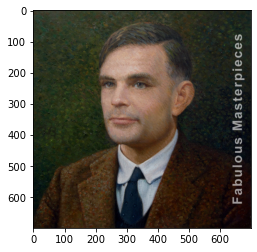

In [66]:
# read the image as rgb values
img = plt.imread('img3.jpg')
# view the image
plt.imshow(img)
dimesion = img.shape
print(dimesion)



In [67]:
# make the rgb values into a single array
img_flat = img.reshape(dimesion[0] * dimesion[1], dimesion[2])

# make a dataframe with the rgb values
df = pd.DataFrame(img_flat)

# add labels to the dataframe
df.columns = ['R', 'G', 'B']

df.describe()

,R,G,B
count,490000.000000,490000.000000,490000.000000
mean,61.969843,55.202382,42.349445
std,49.362423,41.247614,41.002967
min,0.000000,0.000000,0.000000
25%,29.000000,28.000000,17.000000
50%,44.000000,44.000000,28.000000
75%,74.000000,64.000000,47.000000
max,224.000000,210.000000,217.000000


## K-Means Clustering 
We will use the K-Means clustering algorithm to segment an image into a number of clusters. We will use the same code used in part 01.

In [68]:
# k means algorithm

# one iteration of a e step of k means algorithm
def e_step(df, mu):
    # calculate the distance between each data point and each mean
    dist = np.zeros((len(df), len(mu)))
    for i in range(len(mu)):
        dist[:, i] = np.linalg.norm(df - mu[i], axis=1)
    # assign each data point to the mean with the smallest distance
    idx = np.argmin(dist, axis=1)
    return idx
# one iteration of a m step of k means algorithm
def m_step(df, idx):
    # calculate the mean of each cluster
    mu = np.zeros((len(np.unique(idx)), len(df.columns)))
    for i in range(len(np.unique(idx))):
        mu[i] = df[idx == i].mean(axis=0)
    # convert the mu to nearest point available in df
    for i in range(len(mu)):
        mu[i] = df.iloc[np.argmin(np.linalg.norm(df - mu[i], axis=1))]
    return mu

def k_means(df, k, max_iter=10000):
    # initialize the means
    mu = np.zeros((k, len(df.columns)))
    for i in range(k):
        mu[i] = df.iloc[np.random.randint(0, len(df))]
    # initialize the clusters
    idx = np.zeros(len(df))
    # initialize the old clusters
    old_idx = np.zeros(len(df))
    # initialize the iteration counter
    iter = 0
    # lets save the idx and mu and cost for each iteration
    idx_mu = []
    # get initial cost
    cost = np.sum(np.linalg.norm(df - mu[idx.astype(int)], axis=1))
    idx_mu.append([idx.copy(), mu.copy(), cost ])
    # run the k means algorithm until convergence
    while iter < max_iter:
        # run the e step
        old_idx = idx.copy()
        idx = e_step(df, mu)
        cost = np.sum(np.linalg.norm(df - mu[idx], axis=1))
        idx_mu.append([idx.copy(), mu.copy(), cost])
        # run the m step
        mu = m_step(df, idx)
        # save the idx and mu and cost for each iteration
        cost = np.sum(np.linalg.norm(df - mu[idx], axis=1))
        idx_mu.append([idx.copy(), mu.copy(), cost])
        # check for convergence
        iter += 1
        if np.array_equal(idx, old_idx):
            break
    # caclutate the cost
    cost = 0
    for i in range(len(idx)):
        cost += np.linalg.norm(df.iloc[i] - mu[idx[i]])

    # store extra information about the algorithm in info dictionary
    # this will be useful for getting insights from the algorithm
    info = {'k': k ,'iter': iter, 'final_cost' : cost, 'idx_mu': idx_mu}
    return idx, mu, info

In [69]:
# lets cluster the data using different values of k
k_range = [2]
# lets run the algorithm for different values of k
clustered_imgs = {}
for k in k_range:
    idx, mu, info = k_means(df, k)
    # save the clustered image
    vector_quant = idx
    code_book = mu
    clustered_imgs[k] = {'vector_quant': vector_quant, 'code_book': code_book}


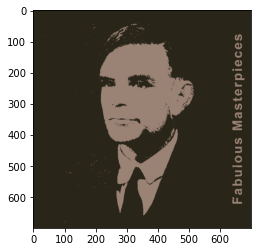

In [ ]:
vq = clustered_imgs[2]['vector_quant']
# get the rgb values for the clustered image using code book
clustered_img = np.zeros((len(vq), len(df.columns)))
for i in range(len(vq)):
    clustered_img[i] = clustered_imgs[2]['code_book'][vq[i]]
clustered_img = clustered_img.reshape(dimesion[0], dimesion[1], dimesion[2])
# view the clustered image
# find distinct values of the clustered image

# convert the clustered image values to nearest integer values
clustered_img = clustered_img.astype(int)
# view the clustered image
plt.imshow(clustered_img)




In [ ]:
def recreateImg(vector_quant, code_book):
    # create an image of the same size as the original
    img_recreated = np.zeros((dimesion[0], dimesion[1], dimesion[2]))
    # assign each pixel the mean of the cluster it belongs to
    for i in range(len(vector_quant)):
        for j in range(len(vector_quant[0])):
            img_recreated[i][j] = code_book[vector_quant[i][j]]
    return img_recreated

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


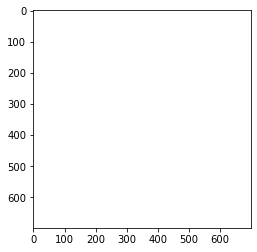

In [ ]:
recreated = recreateImg(clustered_imgs[2]['vector_quant'], clustered_imgs[2]['code_book'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


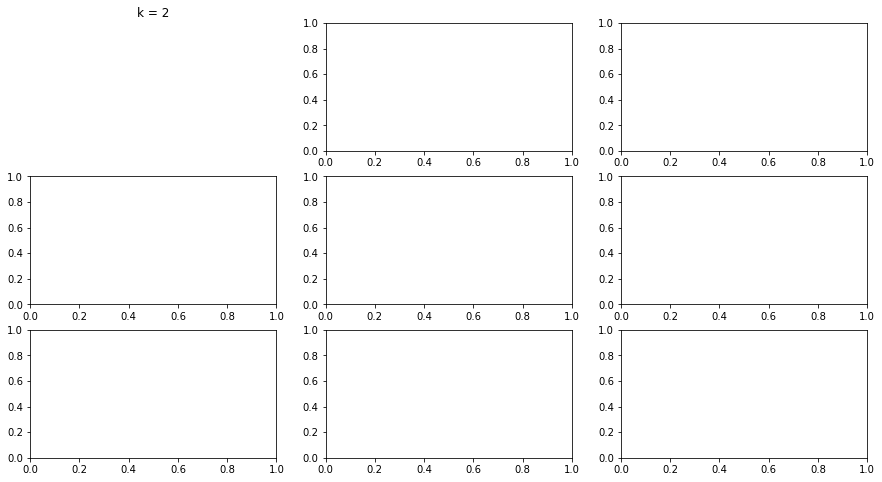

In [ ]:
# plot the clustered images as subplots
fig, ax = plt.subplots(3, 3, figsize=(15, 8))
for i in range(3):
    for j in range(3):
        k = i * 3 + j + 2
        if k in clustered_imgs:
            ax[i][j].imshow(recreateImg(clustered_imgs[k]['vector_quant'], clustered_imgs[k]['code_book']))
            ax[i][j].set_title('k = ' + str(k))
            ax[i][j].axis('off')
